# Curing your data preprocessing blues

## How I Learned to Stop Encoding and Love the QLattice

Data preprocessing is a necessary, but time-consuming, part of any data scientist's workflow. In this article, I'll talk about [Abzu](https://abzu.ai/)'s product, the `QLattice` and the python library, `Feyn`, and how it can help you spend less time on data preprocessing for machine learning tasks - and give you a few bonuses on the way.

We're going to go through a data example using a pizza menu I've spent all my spare time digitizing for exactly this purpose.

I'm gonna do a short recap on the `QLattice`, but otherwise assume that you've read or will [read this for more information](https://docs.abzu.ai/docs/guides/qlattice.html).

We also have a fun, lighter read [introducing the QLattice](https://medium.com/abzuai/a-new-kind-of-ai-7665f8198877).

## TLDR; on the QLatttice

![Quantum Lattice](https://media.giphy.com/media/l1J3ncbG9KusoZwsw/giphy.gif)

The `QLattice` (short for Quantum Lattice) is a machine learning approach developed by [Abzu](https://abzu.ai/) that lets you use an evolutionary approach to finding the best models for your data problem. This is done by continually updating the `QLattice` with your best model structures to narrow the search field and come up with better models as you have them compete with each other.

Training works by asking your `QLattice` to generate thousands of graphs (the `QGraph`) containing mappings between your inputs and output, training them and updating your `QLattice` to get even more, and better, graphs.

This is done using a python library called `Feyn` \[/ˈfaɪn/\], which you can pip install on Windows, OS X, or Linux.

If you want to follow along, [you can sign up for free here](https://abzu.ai/sign-up/?code=datasciencemedium).

# Let's load in the data real quick

We're using `pandas` to load this up real quick from a csv.

In [1]:
import pandas as pd

pizza = pd.read_csv('pizza_dataset.csv').drop(['no', 'name', 'ingredients'], axis=1)
pizza

,type,price,size,vegetarian,dairy,fish,ingredient_count
0,Pizza,42,lunch,False,True,False,4
1,Pizza,42,lunch,True,True,False,4
2,Pizza,42,lunch,False,True,False,4
3,Pizza,42,lunch,False,True,False,4
4,Pizza,42,lunch,False,True,False,4
...,...,...,...,...,...,...,...
167,Pizza,103,family,True,True,False,3
168,Pizza,79,regular,False,True,False,6
169,Pizza,128,family,False,True,False,6
170,Pizza,79,regular,False,True,False,7


We've dropped some unique identifiers to avoid encouraging memorization, and that holds for the comma-separated list of ingredients in the dataset too (since they're mostly unique per pizza). We have kept tangential information instead. We could do further work to use more of the ingredients feature, but we'll leave that as an exercise for now as our objective is not training a perfect model.

After loading, admittedly, this dataset is already a lot nicer than what you'd find in the wild, so it contains no NaN or otherwise missing values.

So with that out of the way, let's take a closer look!

## The bare necessities

This next part, depending on algorithm, would normally be about data preparation before training, and that’s where `Feyn` comes to your aid. 

With `Feyn`, we've taken a page out of the pythonic stylebook, and one of the core features is the batteries-included approach of just being able to drop in a dataset, and start extracting `QGraphs`. All the rest happens under the hood.

The only thing you need to consider is whether or not your column is:
* Numerical
* Categorical

And that’s it. Let's take it for a spin!

# Connection link established

![hacker voice I'm in](https://media.giphy.com/media/3FQ87l4tXAZWGvV3yY/giphy.gif)

Let's first connect to our QLattice. I'm using a local config file so I don't need to specify a token. You can run this without authentication in our [interactive JupyterLab environment](https://jupyter.abzu.ai), or locally using your own URL and Token to authenticate.

In [2]:
import feyn

ql = feyn.QLattice(config="PizzaExample")
ql.reset()

In [3]:
feyn.__version__

'1.2.0'

Let's have a look at our data types, and also present a helper function that creates a dict mapping your categorical input to what we call the 'categorical' semantic type. This function just guesses it based off of the pandas datatypes, but you could manually create it as well.

In [4]:
pizza.dtypes

type                object
price                int64
size                object
vegetarian            bool
dairy                 bool
fish                  bool
ingredient_count     int64
dtype: object

In [5]:
def guess_categorical(df, ql):
    cat_dict = dict()
    for col in df.columns:
        if df[col].dtype == 'object':
            # Strings are categorical
            cat_dict[col] = 'cat'
    return cat_dict

In [6]:
cats = guess_categorical(pizza, ql)

And Bob's your uncle!

## Wait, was that it?

Yeah, that was really it. Now you just need to provide this dict in the stypes parameter when fitting your `QGraph`.

Notice how we haven't even fed any data into it yet. So far, we've only been working on the conceptual level of the problem domain.

That's pretty neat!

# So let's train a model using the QLattice

Let's just split the dataset into train and test for evaluation.

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pizza, random_state=42)

Next we'll run an update loop for our QLattice, training it on our pizza dataset to predict the price. We're gonna gloss over this, but [read the docs](https://docs.abzu.ai) if you're curious for more.

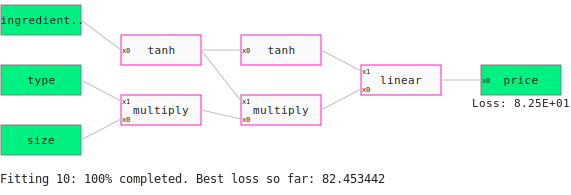

In [8]:
#The number of update loops we are going to perform
updates = 10

# First extract the QGraph using data columns to denote inputs and output
# Note the stypes=cats points to our categorical mapping further up.
qgraph = ql.get_qgraph(pizza.columns, output="price", stypes=cats, max_depth=3)

for loop in range(updates):
    # Fit each model in the QGraph
    qgraph.fit(train) 
    
    # Select the best model after training
    best = qgraph.sort(train)[0] 
    
    # Update the QLattice with the best model
    ql.update(best)

Without getting into too much detail on the fitting process, what it does is it always shows the currently best performing graph. After finally sorting by train loss and getting the best graph, this can be a different graph, which we show below

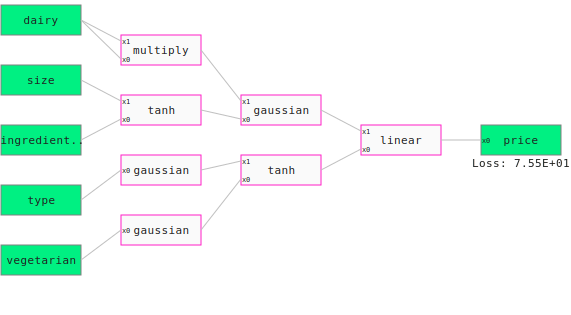

In [9]:
best

## Let's quickly evaluate the solution

It's important to stop and check that what we have makes sense, so let's check out the RMSE on the train and test set. The prices are in DKK.

In [10]:
import numpy as np

In [11]:
def rmse(pred, truth):
    return np.sqrt(((pred - truth)**2).mean())

pred_train = best.predict(train)
pred_test = best.predict(test)

In [12]:
rmse(pred_train, train.price)

8.688198938732636

In [13]:
rmse(pred_test, test.price)

13.48993755016472

We see a slight bit of overfitting, but good enough for our purposes.
Let's plot it real quick.

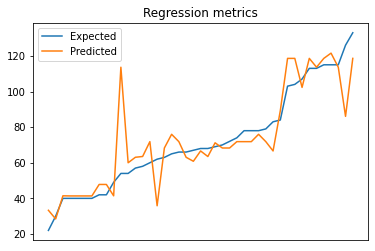

In [14]:
from feyn import tools
tools.plot_regression_metrics(test.price, pred_test)

## Looking into the semantic types

![registers](https://media.giphy.com/media/l2JebahZUckTgBfUY/giphy.gif)

Since the exact graph can change between runs and we can't guarantee ordering of cells, or even that they're present, I've declared a simple function to help us inspect the graphs, but let's back up first with some theory.

In [15]:
from IPython.display import display
def display_state(graph, name):
    """ A little helper function to inspect the state """
    for interaction in graph:
        if interaction.name == name:            
            display(f"Name: {interaction.name}")
            display(interaction.state._to_dict())
            break

`Feyn` has two kinds of `stypes`, the `numerical` and `categorical` `semantic type`.

## The numerical semantic type

The default behaviour in `Feyn` is standardisation, using something like the MinMaxScaler you might already know and love from `sklearn`. It works on a register level, and auto-scales your inputs to be within -1 and 1 based on the minimum and maximum value it sees. The output register has the exact same behaviour, but also ensures that your output is automatically destandardised to your expected values.

Let's look at the ones from our trained graph:

In [16]:
display_state(best, 'ingredient_count')

'Name: ingredient_count'

{'feature_min': 1.0, 'feature_max': 9.0, 'auto_adapt': True}

The first interaction in the graph is 'ingredient_count', and as you can read from the state, it has detected the minimum value 1.0 and the maximum value of 9.

In [17]:
display_state(best, 'vegetarian')

'Name: vegetarian'

{'feature_min': 0.0, 'feature_max': 1.0, 'auto_adapt': True}

The second interaction is 'vegetarian', which is a boolean feature, and `Feyn` has detected the min value of 0 and max value of 1. So this has just resulted in a recentering around 0.

## The categorical semantic type

![the category is love](https://media.giphy.com/media/ggooIjlyc1EG2QxkeS/giphy.gif)

So what's the magic behind the variables? The `categorical semantic type` is essentially a kind of auto-adapting one-hot encoding. Let's take an example:

Suppose you have the pizza menu, and you have three types of pizza offers: `regular`, `family` and `lunch`. A traditional one-hot encoding approach would convert these into three mutually exclusive features: `is_regular`, `is_family`, and `is_lunch`.

What `Feyn` does is similar, but instead assigns a weight to each category that will be adjusted during training. So when you pass in a pizza that is family-sized, it'll use the weights for family-sized pizzas, and the same for regular and lunch offers. Unlike one-hot encoding, all of this happens within the same feature node.

Let's get real:

In [18]:
display_state(best, 'size')

'Name: size'

{'categories': [('lunch', -0.5290920195420976),
  ('regular', 0.07793374379814877),
  ('family', 0.28942957434802774)]}

We can see for this interaction that it has learned a weight for each feature value. By looking at this, we can also see which values drive higher separation. For instance, 'family' has learned a high weight (close to 1), regular is a bit to the positive side of 0 (the center) and 'lunch' has a slight negative weight.

Interpreting this requires you to look at the full graph, but we see clear separation already where we can guess that family and regular drive higher prices than lunch.

In [19]:
display_state(best, 'type')

'Name: type'

{'categories': [('Panini', -0.20331584135126946),
  ('Pizza', -0.40433235139414725),
  ('Salad', 0.003917517012023808),
  ('Pasta', -0.4284522321873805),
  ('Starter', 0.2604060329575404)]}

The same as above is experienced on the type, where we can see pizzas and pasta commanding higher separation than salads and paninis, and the starters driving to the negative, gisting at lowering the prediction for price.

## So what does this mean?

[In this post, we dive even deeper](https://medium.com/abzuai/opening-the-black-box-247a63ce553e) into the graphs. We'll also further explore how to get insights into your graphs in future series. Hopefully, you've learned something new on how the semantic types save you time with data preprocessing, and how the categorical semantic type can even help you on the way of getting insights out of your data and models you wouldn't have seen otherwise.

You'll also have more insights the next time you order a pizza with three extra servings of cheese and you wonder about the price spike.

If you're tempted to take a look yourself, [head on over here and sign up for a QLattice!](https://abzu.ai/sign-up/?code=datasciencemedium)